# Practice6 (test_submission1_5, 2_5.csv)
> Public Score
> - test_submission1_3:
> - test_submission2_3:

In [98]:
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# column 보기 30개로 설정
pd.set_option('display.max_columns', 30)

In [99]:
# 데이터 경로 설정
file_path = os.path.join(os.getcwd(), 'data')
train_origin = pd.read_csv(file_path+'\dataset.csv')
test_origin = pd.read_csv(file_path+'\problem.csv')

In [100]:
train_origin.shape, test_origin.shape

((1340, 24), (130, 23))

In [101]:
# 전처리를 위한 원본 데이터 복사
train = train_origin.copy()
test = test_origin.copy()

In [102]:
# 메모리를 효율적으로 사용하기 위한 downcast 함수 정의
def downcast(df, verbose=True):     # verbose 옵션 추가: (True)인 경우 몇 퍼센트 압축됐는지 출력
    start_mem = df.memory_usage().sum() / 1024**2   # 초기 메모리 사용량
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'{(100*(start_mem - end_mem) / start_mem):.1f}% 압축됨')

    return df

In [103]:
downcast(train)
downcast(test)

67.2% 압축됨
68.7% 압축됨


Id  LotArea Street LotConfig  OverallQual  OverallCond  YearBuilt  \
0    1341    11200   Pave    Inside            5            5       1965   
1    1342     7200   Pave    Corner            5            7       1951   
2    1343    16905   Pave    Inside            5            6       1959   
3    1344     9180   Pave   CulDSac            5            7       1983   
4    1345     7200   Pave    Inside            5            7       1920   
..    ...      ...    ...       ...          ...          ...        ...   
125  1466    11478   Pave    Inside            8            5       2007   
126  1467    16321   Pave   CulDSac            5            6       1957   
127  1468     6324   Pave    Inside            4            6       1927   
128  1469     8500   Pave    Inside            4            4       1920   
129  1470     8544   Pave   CulDSac            5            6       1966   

     YearRemodAdd  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  FullBath  \
0            1965         1040      1040         0       1040         1   
1            2000          900       900         0        900         1   
2            1959         1350      1328         0       1328         1   
3            1983          840       884         0        884         1   
4            1996          530       581       530       1111         1   
..            ...          ...       ...       ...        ...       ...   
125          2008         1704      1704         0       1704         2   
126          1997         1484      1600         0       1600         1   
127          1950          520       520         0        520         1   
128          1950          649       649       668       1317         1   
129          2006         1228      1228         0       1228         1   

     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0           0             3             1             5           0   
1           0             3             1             5           0   
2           1             2             1             5           2   
3           0             2             1             5           0   
4           0             3             1             6           0   
..        ...           ...           ...           ...         ...   
125         0             3             1             7           1   
126         0             2             1             6           2   
127         0             1             1             4           0   
128         0             3             1             6           0   
129         1             3             1             6           0   

    GarageType  GarageYrBlt  GarageCars  GarageArea  YrSold  
0       Detchd         1965           1         384    2008  
1       Detchd         2005           2         576    2010  
2       Attchd         1959           1         308    2007  
3       Attchd         1983           2         504    2007  
4       Detchd         1935           1         288    2007  
..         ...          ...         ...         ...     ...  
125     Attchd         2008           3         772    2010  
126     Attchd         1957           1         319    2006  
127     Detchd         1920           1         240    2008  
128     Detchd         1920           1         250    2008  
129     Attchd         1966           1         271    2008  

[130 rows x 23 columns]

# 전처리

### 결측치 처리

In [104]:
train.isnull().sum()

Id               0
LotArea          0
Street           0
LotConfig        0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageType      81
GarageYrBlt     81
GarageCars       0
GarageArea       0
YrSold           0
SalePrice        0
dtype: int64

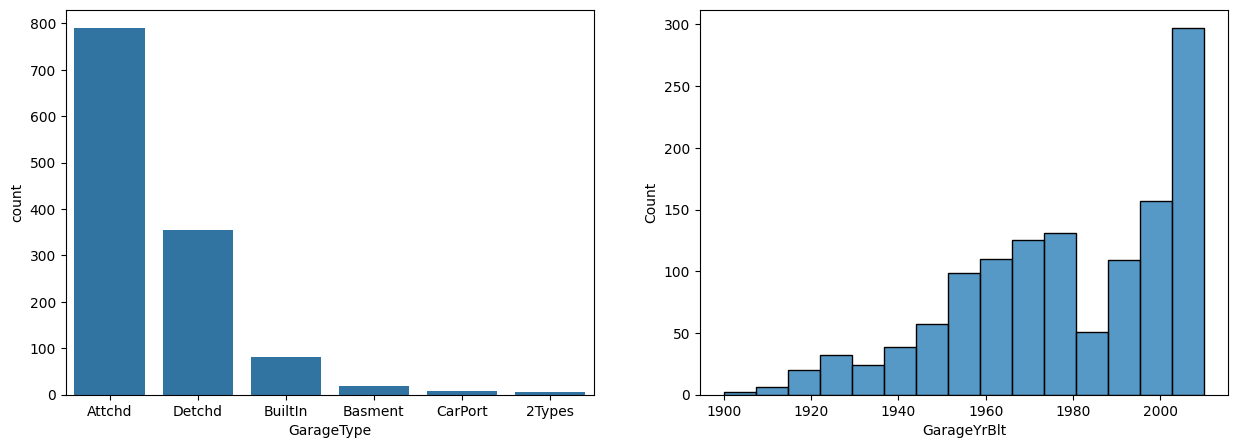

In [105]:
# 결측치 column 확인
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)    # GarageType 막대그래프
sns.barplot(train['GarageType'].value_counts())

plt.subplot(1, 2, 2)    # GarageYrBlt 히스토그램
sns.histplot(train['GarageYrBlt'])

plt.show()

In [106]:
# 최빈값 대체
train['GarageType'].fillna(train['GarageType'].mode()[0], inplace=True)
train['GarageYrBlt'].fillna(train['GarageYrBlt'].mode()[0], inplace=True)

In [107]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

### Feature engineering

In [108]:
train['YearBuilt'].max()      # 최신에 지어진 건물 연도 확인

2010

In [109]:
# 2010년을 기준으로 건물이 지어진 후 지난 시간(연)
train['YearBuiltDiff'] = 2010 - train['YearBuilt']
test['YearBuiltDiff'] = 2010 - test['YearBuilt']

In [110]:
train['YearRemodAdd'].max()     # 리모델링 연도 확인

2010

In [111]:
# 리모델링 후 지난 시간(연)
train['RemodAddDiff'] = 2010 - train['YearRemodAdd']
test['RemodAddDiff'] = 2010 - test['YearRemodAdd']

In [112]:
# FullBath + HalfBath = TotalBath
train['TotalBath'] = train['FullBath'] + train['HalfBath']
test['TotalBath'] = test['FullBath'] + test['HalfBath']

In [113]:
# GrLivArea + TotalBsmtSF = TotalSF(총 평방피트)
train['TotalSF'] = train['GrLivArea'] + train['TotalBsmtSF']
test['TotalSF'] = test['GrLivArea'] + test['TotalBsmtSF']

In [114]:
# 2층이 0인 경우가 꽤 많기 때문에 2층 여부 feature 추가
train['Has2ndFlr'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['Has2ndFlr'] = test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

In [115]:
# 지하실 여부 feature 추가
train['HasBsmt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasBsmt'] = test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

### 일부 feature 제거

In [116]:
no_use_features = ['Id', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'TotRmsAbvGrd']

In [117]:
train.drop(no_use_features, axis=1, inplace=True)
test.drop(no_use_features, axis=1, inplace=True)

### 중복 데이터 제거

In [118]:
train.duplicated().sum()    # 중복 데이터 확인

2

In [119]:
train = train.drop_duplicates()     # 중복 데이터 제거

### 이상치 처리
> target 값인 SalePrice와 그와 상관관계가 매우 높은 몇 가지 feature만 이상치 처리를 좀 해주자.

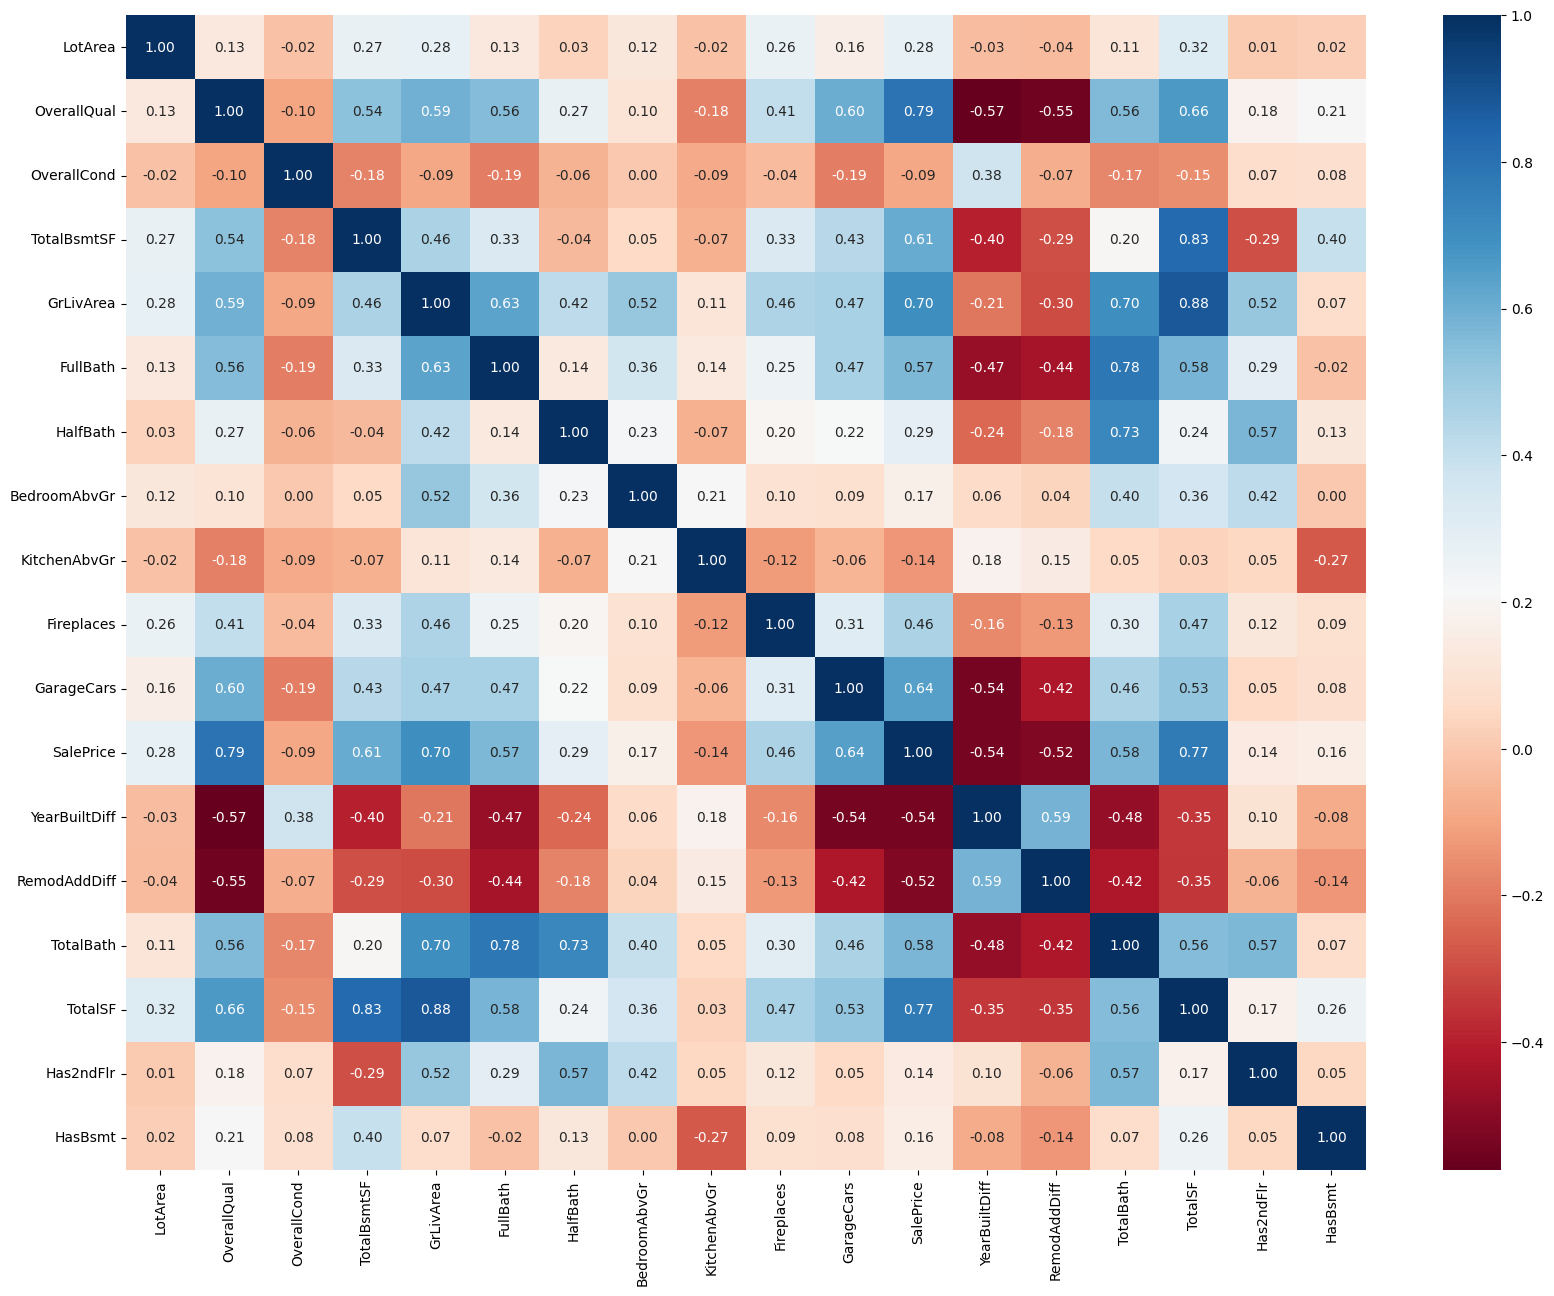

In [120]:
# 상관계수 히트맵
numeric_data = train.select_dtypes(exclude="object")   # 수치형 데이터만 추출
plt.figure(figsize=(20, 15))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='RdBu')    # 절반만 표시하고 싶은 경우 mask=mask 옵션 추가
plt.show()

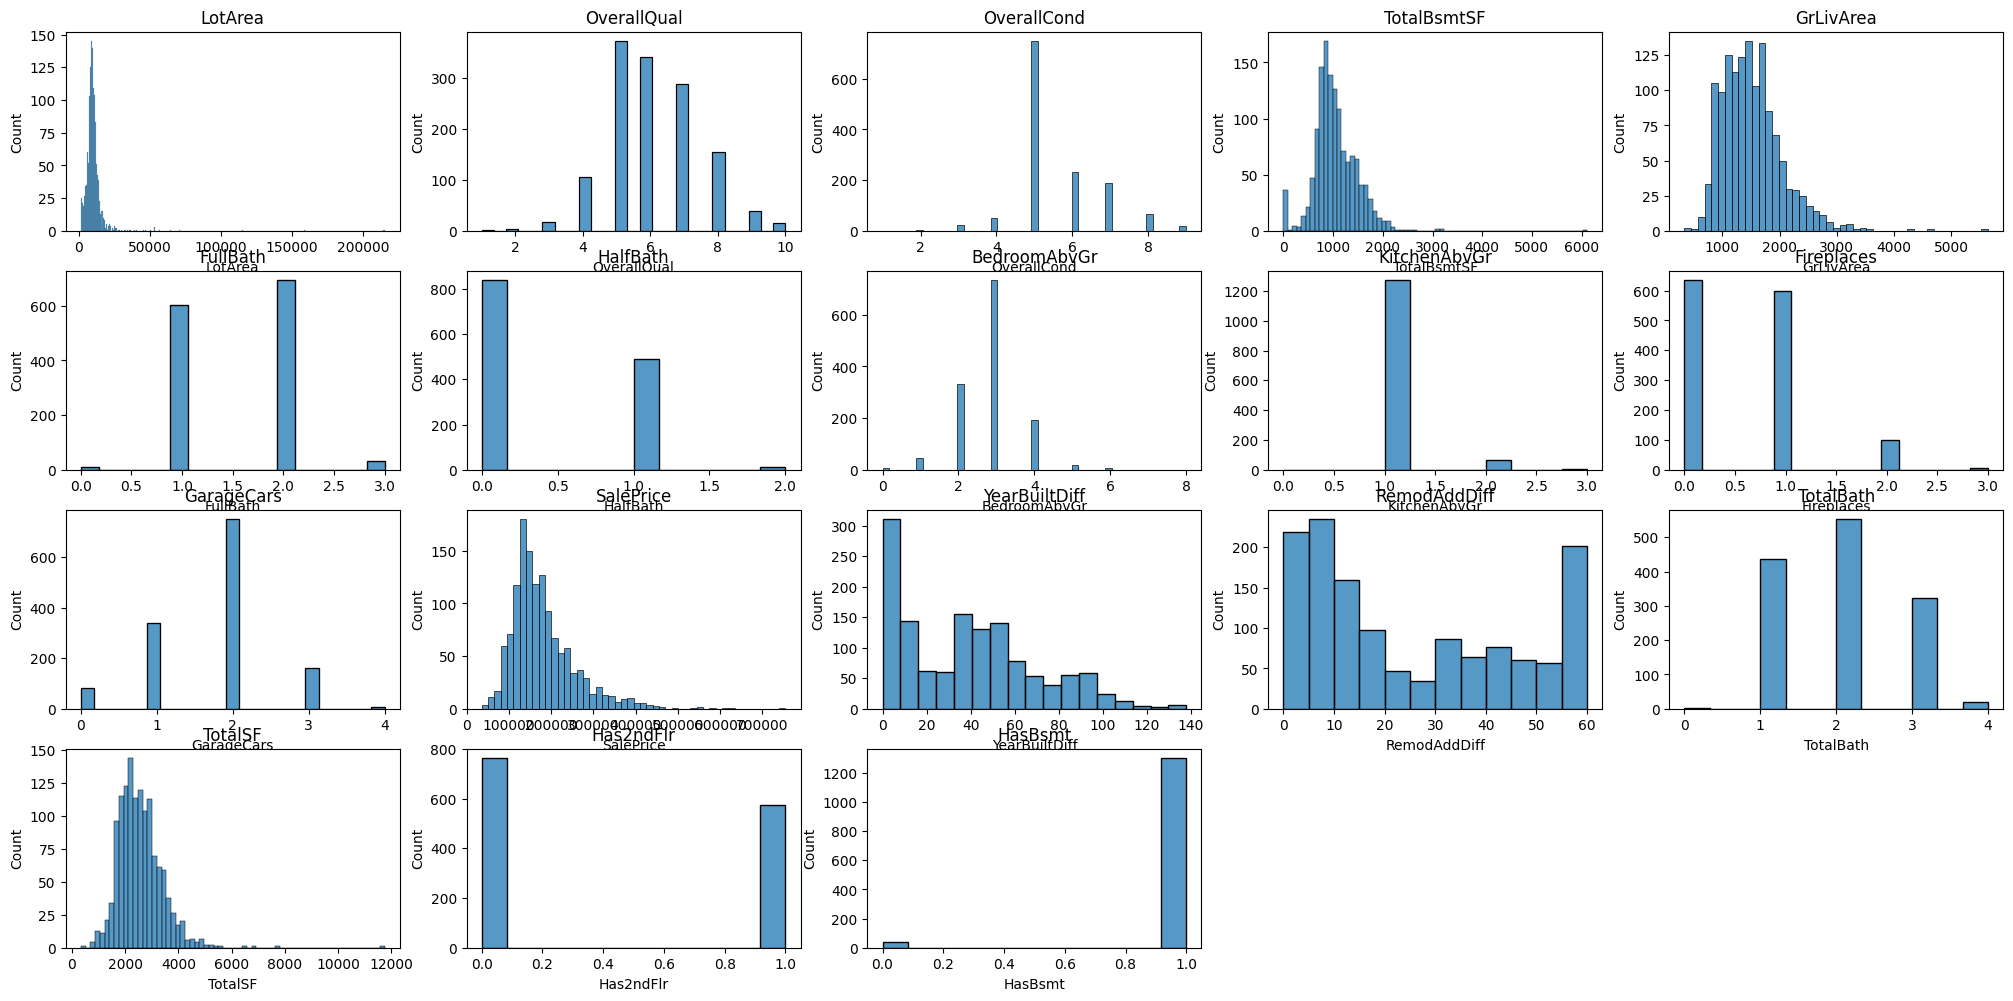

In [121]:
# 모든 수치형 변수의 히스토그램 한 번에 시각화
plt.figure(figsize=(25, 15))
for i, col in enumerate(numeric_data.columns):
    plt.subplot(5, 5, i+1)
    sns.histplot(train[col], kde=False)
    plt.title(col)

> GrLivArea

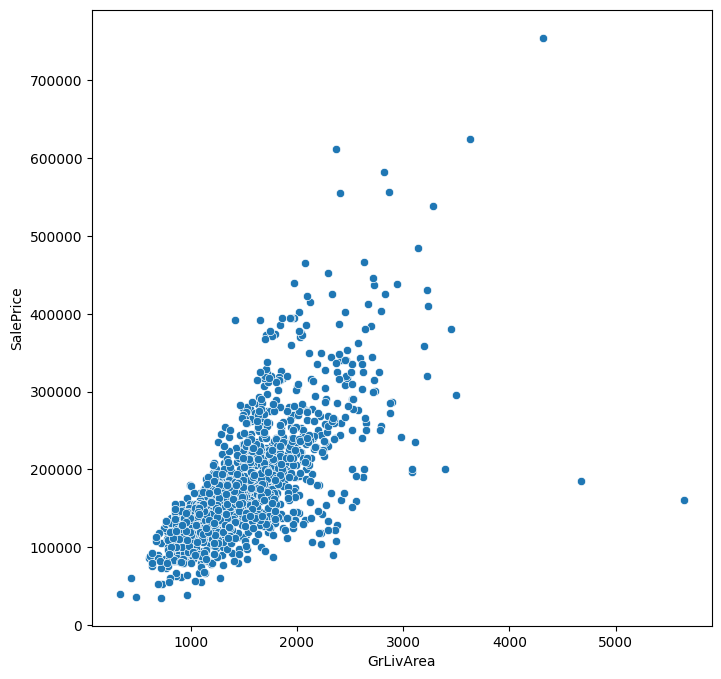

In [122]:
# GrLivArea와 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')
plt.show()

In [123]:
# 이상치 제거
outlier_index = train[(train['SalePrice']<220000)&(train['GrLivArea']>4000)]
train = train.drop(outlier_index.index).reset_index(drop=True)

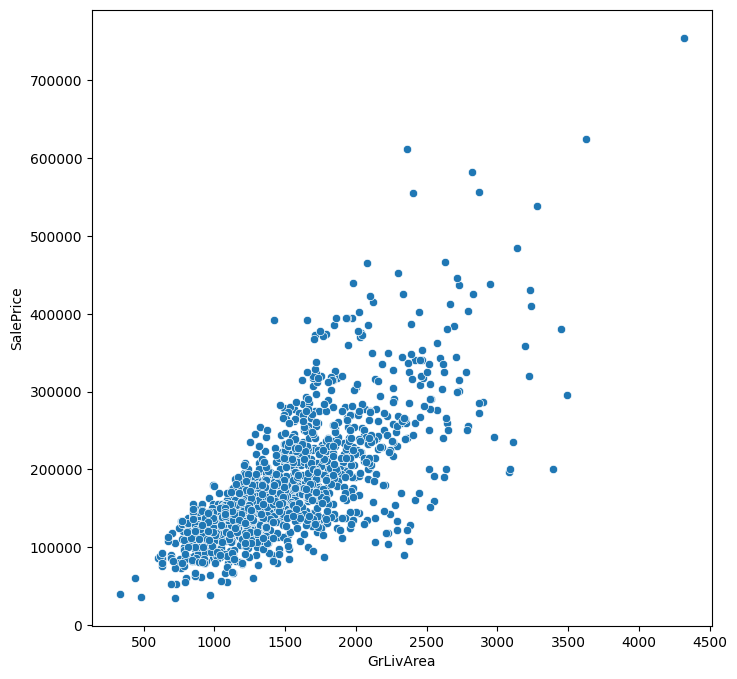

In [124]:
# GrLivArea와 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')
plt.show()

> TotalBsmtSF

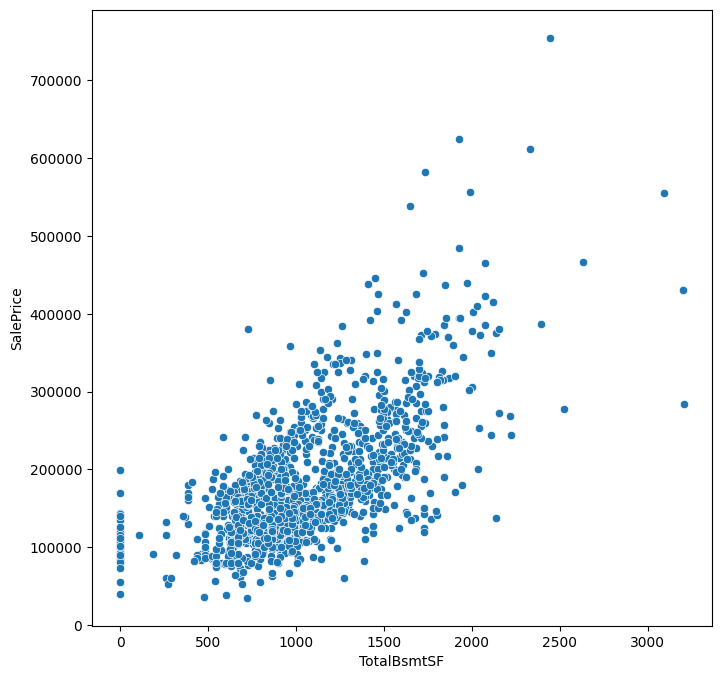

In [125]:
# OverallQual과 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice')
plt.show()

> LotArea 이상치 제거

<Axes: ylabel='LotArea'>

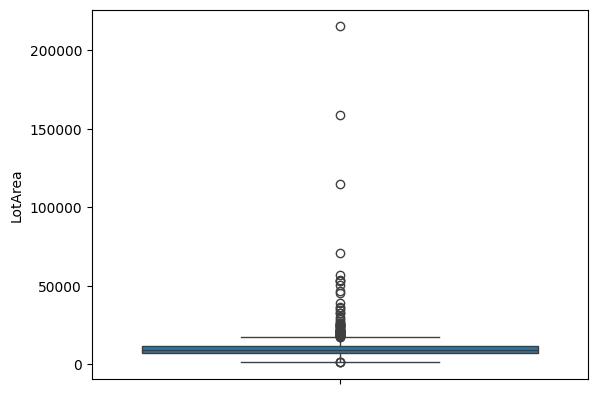

In [128]:
sns.boxplot(train['LotArea'])

In [131]:
# LotArea 이상치 제거
train = train[train['LotArea'] < 100000].reset_index(drop=True)

### 수치형 변수들 편향도 확인

In [133]:
numeric_cat = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'SalePrice']

for i in numeric_cat:
    skewed_value = train[i].skew()
    print(f'{i}의 왜도: {skewed_value:.2f}')

    log_value = np.log1p(train[i])
    print(f'로그 변환 후 {i}의 왜도: {log_value.skew():.2f}')

LotArea의 왜도: 4.17
로그 변환 후 LotArea의 왜도: -0.71
TotalBsmtSF의 왜도: 0.52
로그 변환 후 TotalBsmtSF의 왜도: -5.04
GrLivArea의 왜도: 0.92
로그 변환 후 GrLivArea의 왜도: -0.08
SalePrice의 왜도: 1.80
로그 변환 후 SalePrice의 왜도: 0.14


> LotArea와 SalePrice의 왜도가 높은 편이니 log변환을 해보자

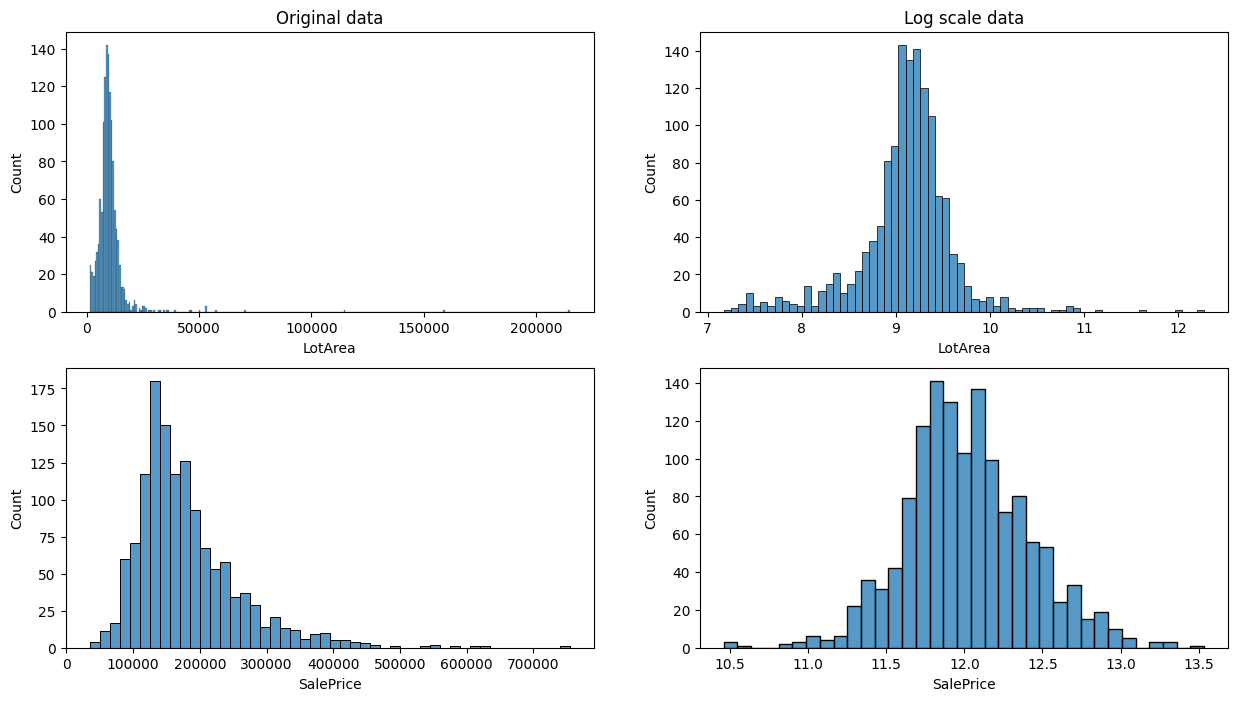

In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.title('Original data')
sns.histplot(train['LotArea'])

plt.subplot(2, 2, 2)
plt.title('Log scale data')
sns.histplot(np.log1p(train['LotArea']))

plt.subplot(2, 2, 3)
sns.histplot(train['SalePrice'])

plt.subplot(2, 2, 4)
sns.histplot(np.log1p(train['SalePrice']))

plt.show()

In [134]:
train['LotArea'] = np.log1p(train['LotArea'])
test['LotArea'] = np.log1p(test['LotArea'])

train['GrLivArea'] = np.log1p(train['GrLivArea'])
test['GrLivArea'] = np.log1p(test['GrLivArea'])

train['SalePrice'] = np.log1p(train['SalePrice'])

### Encoding

In [135]:
# X, y 분리
X_train = train.drop(columns='SalePrice', axis=1)
y_train = train['SalePrice']

In [136]:
all_data = pd.concat([X_train, test], axis=0).reset_index(drop=True)

In [137]:
all_data

LotArea Street LotConfig  OverallQual  OverallCond  TotalBsmtSF  \
0     9.042040   Pave    Inside            7            5          856   
1     9.169623   Pave       FR2            6            8         1262   
2     9.328212   Pave    Inside            7            5          920   
3     9.164401   Pave    Corner            7            5          756   
4     9.565284   Pave       FR2            8            5         1145   
...        ...    ...       ...          ...          ...          ...   
1458  9.348275   Pave    Inside            8            5         1704   
1459  9.700269   Pave   CulDSac            5            6         1484   
1460  8.752265   Pave    Inside            4            6          520   
1461  9.047939   Pave    Inside            4            4          649   
1462  9.053102   Pave   CulDSac            5            6         1228   

      GrLivArea  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  Fireplaces  \
0      7.444833         2         1             3             1           0   
1      7.141245         2         0             3             1           1   
2      7.488294         2         1             3             1           1   
3      7.448916         1         0             3             1           1   
4      7.695758         2         1             4             1           1   
...         ...       ...       ...           ...           ...         ...   
1458   7.441320         2         0             3             1           1   
1459   7.378384         1         0             2             1           2   
1460   6.255750         1         0             1             1           0   
1461   7.183871         1         0             3             1           0   
1462   7.113956         1         1             3             1           0   

     GarageType  GarageCars  YearBuiltDiff  RemodAddDiff  TotalBath  TotalSF  \
0        Attchd           2              7             7          3     2566   
1        Attchd           2             34            34          2     2524   
2        Attchd           2              9             8          3     2706   
3        Detchd           3             95            40          1     2473   
4        Attchd           3             10            10          3     3343   
...         ...         ...            ...           ...        ...      ...   
1458     Attchd           3              3             2          2     3408   
1459     Attchd           1             53            13          1     3084   
1460     Detchd           1             83            60          1     1040   
1461     Detchd           1             90            60          1     1966   
1462     Attchd           1             44             4          2     2456   

      Has2ndFlr  HasBsmt  
0             1        1  
1             0        1  
2             1        1  
3             1        1  
4             1        1  
...         ...      ...  
1458          0        1  
1459          0        1  
1460          0        1  
1461          1        1  
1462          0        1  

[1463 rows x 20 columns]

In [ ]:
# # 일부 column들은 숫자형이지만 실제로는 범주형 변수이므로 object로 변환
# object_cat = ['OverallQual', 'OverallCond', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'YearBuiltDiff', 'RemodAddDiff', 'TotalBath', 'Has2ndFlr']

# for i in object_cat:
#     all_data[i] = all_data[i].astype('object')

In [138]:
# 일부 category는 OHE
OHE_cat = ['Street', 'LotConfig', 'GarageType']

all_data = pd.get_dummies(all_data, columns=OHE_cat)

In [139]:
all_data

LotArea  OverallQual  OverallCond  TotalBsmtSF  GrLivArea  FullBath  \
0     9.042040            7            5          856   7.444833         2   
1     9.169623            6            8         1262   7.141245         2   
2     9.328212            7            5          920   7.488294         2   
3     9.164401            7            5          756   7.448916         1   
4     9.565284            8            5         1145   7.695758         2   
...        ...          ...          ...          ...        ...       ...   
1458  9.348275            8            5         1704   7.441320         2   
1459  9.700269            5            6         1484   7.378384         1   
1460  8.752265            4            6          520   6.255750         1   
1461  9.047939            4            4          649   7.183871         1   
1462  9.053102            5            6         1228   7.113956         1   

      HalfBath  BedroomAbvGr  KitchenAbvGr  Fireplaces  GarageCars  \
0            1             3             1           0           2   
1            0             3             1           1           2   
2            1             3             1           1           2   
3            0             3             1           1           3   
4            1             4             1           1           3   
...        ...           ...           ...         ...         ...   
1458         0             3             1           1           3   
1459         0             2             1           2           1   
1460         0             1             1           0           1   
1461         0             3             1           0           1   
1462         1             3             1           0           1   

      YearBuiltDiff  RemodAddDiff  TotalBath  TotalSF  Has2ndFlr  HasBsmt  \
0                 7             7          3     2566          1        1   
1                34            34          2     2524          0        1   
2                 9             8          3     2706          1        1   
3                95            40          1     2473          1        1   
4                10            10          3     3343          1        1   
...             ...           ...        ...      ...        ...      ...   
1458              3             2          2     3408          0        1   
1459             53            13          1     3084          0        1   
1460             83            60          1     1040          0        1   
1461             90            60          1     1966          1        1   
1462             44             4          2     2456          0        1   

      Street_Grvl  Street_Pave  LotConfig_Corner  LotConfig_CulDSac  \
0           False         True             False              False   
1           False         True             False              False   
2           False         True             False              False   
3           False         True              True              False   
4           False         True             False              False   
...           ...          ...               ...                ...   
1458        False         True             False              False   
1459        False         True             False               True   
1460        False         True             False              False   
1461        False         True             False              False   
1462        False         True             False               True   

      LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  GarageType_2Types  \
0             False          False              True              False   
1              True          False             False              False   
2             False          False              True              False   
3             False          False             False              False   
4              True          False             False              False   
.

In [140]:
# 공통 전처리 끝
X_train = all_data.iloc[:len(X_train)]
test = all_data.iloc[len(X_train):].reset_index(drop=True)

In [141]:
X_train.shape, test.shape

((1333, 30), (130, 30))

In [146]:
# 수치형 변수들 Robust Scaling
from sklearn.preprocessing import RobustScaler

cols = ['LotArea', 'TotalBsmtSF', 'GrLivArea']

scaler = RobustScaler().fit(X_train[cols])

X_train.loc[:, cols] = scaler.transform(X_train[cols])
test.loc[:, cols] = scaler.transform(test[cols])

In [147]:
X_train

LotArea  OverallQual  OverallCond  TotalBsmtSF  GrLivArea  FullBath  \
0    -0.262162            7            5    -0.257143   0.351641         2   
1     0.036348            6            8     0.571429  -0.312672         2   
2     0.407407            7            5    -0.126531   0.446741         2   
3     0.024131            7            5    -0.461224   0.360575         1   
4     0.962093            8            5     0.332653   0.900715         2   
...        ...          ...          ...          ...        ...       ...   
1328 -0.414587            6            5    -0.059184   0.269549         2   
1329  0.776946            6            6     1.142857   0.772653         2   
1330 -0.103747            7            9     0.346939   1.037643         2   
1331  0.064688            5            6     0.195918  -0.657216         1   
1332  0.117066            5            6     0.559184  -0.323092         1   

      HalfBath  BedroomAbvGr  KitchenAbvGr  Fireplaces  GarageCars  \
0            1             3             1           0           2   
1            0             3             1           1           2   
2            1             3             1           1           2   
3            0             3             1           1           3   
4            1             4             1           1           3   
...        ...           ...           ...         ...         ...   
1328         1             3             1           1           2   
1329         0             3             1           2           2   
1330         0             4             1           2           1   
1331         0             2             1           0           1   
1332         1             3             1           0           1   

      YearBuiltDiff  RemodAddDiff  TotalBath  TotalSF  Has2ndFlr  HasBsmt  \
0                 7             7          3     2566          1        1   
1                34            34          2     2524          0        1   
2                 9             8          3     2706          1        1   
3                95            40          1     2473          1        1   
4                10            10          3     3343          1        1   
...             ...           ...        ...      ...        ...      ...   
1328             11            10          3     2600          1        1   
1329             32            22          2     3615          0        1   
1330             69             4          2     3492          1        1   
1331             60            14          1     2156          0        1   
1332             45            45          2     2512          0        1   

      Street_Grvl  Street_Pave  LotConfig_Corner  LotConfig_CulDSac  \
0           False         True             False              False   
1           False         True             False              False   
2           False         True             False              False   
3           False         True              True              False   
4           False         True             False              False   
...           ...          ...               ...                ...   
1328        False         True             False              False   
1329        False         True             False              False   
1330        False         True             False              False   
1331        False         True             False              False   
1332        False         True             False              False   

      LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  GarageType_2Types  \
0             False          False              True              False   
1              True          False             False              False   
2             False          False              True              False   
3             False          False             False              False   
4              True          False             False              False   
.

In [148]:
test

LotArea  OverallQual  OverallCond  TotalBsmtSF  GrLivArea  FullBath  \
0    0.396986            5            5     0.118367  -0.735669         1   
1   -0.636672            5            7    -0.167347  -1.051715         1   
2    1.360177            5            6     0.751020  -0.201211         1   
3   -0.068311            5            7    -0.289796  -1.090922         1   
4   -0.636672            5            7    -0.922449  -0.591295         1   
..        ...          ...          ...          ...        ...       ...   
125  0.454348            8            5     1.473469   0.343954         2   
126  1.277924            5            6     1.024490   0.206235         1   
127 -0.940160            4            6    -0.942857  -2.250315         1   
128 -0.248360            4            4    -0.679592  -0.219398         1   
129 -0.236281            5            6     0.502041  -0.372386         1   

     HalfBath  BedroomAbvGr  KitchenAbvGr  Fireplaces  GarageCars  \
0           0             3             1           0           1   
1           0             3             1           0           2   
2           1             2             1           2           1   
3           0             2             1           0           2   
4           0             3             1           0           1   
..        ...           ...           ...         ...         ...   
125         0             3             1           1           3   
126         0             2             1           2           1   
127         0             1             1           0           1   
128         0             3             1           0           1   
129         1             3             1           0           1   

     YearBuiltDiff  RemodAddDiff  TotalBath  TotalSF  Has2ndFlr  HasBsmt  \
0               45            45          1     2080          0        1   
1               59            10          1     1800          0        1   
2               51            51          2     2678          0        1   
3               27            27          1     1724          0        1   
4               90            14          1     1641          1        1   
..             ...           ...        ...      ...        ...      ...   
125              3             2          2     3408          0        1   
126             53            13          1     3084          0        1   
127             83            60          1     1040          0        1   
128             90            60          1     1966          1        1   
129             44             4          2     2456          0        1   

     Street_Grvl  Street_Pave  LotConfig_Corner  LotConfig_CulDSac  \
0          False         True             False              False   
1          False         True              True              False   
2          False         True             False              False   
3          False         True             False               True   
4          False         True             False              False   
..           ...          ...               ...                ...   
125        False         True             False              False   
126        False         True             False               True   
127        False         True             False              False   
128        False         True             False              False   
129        False         True             False               True   

     LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  GarageType_2Types  \
0            False          False              True              False   
1            False          False             False              False   
2            False          False              True              False   
3            False          False             False              False   
4            False          False              True              False   
..             ...            ...               ...   

# Model training

In [43]:
# optuna 최적화
import optuna
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

def RMSE_expm1(y_pred, y_true):
    return np.sqrt(np.mean(np.square(np.expm1(y_pred) - np.expm1(y_true))))


def objective(trial):
    params = {
        'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.5),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
    }

    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    scores = []
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        xgb_model = XGBRegressor(**params, random_state=42)
        xgb_model.fit(X_train_fold, y_train_fold)
        y_pred = xgb_model.predict(X_val_fold)
        scores.append(RMSE_expm1(y_pred, y_val_fold))

    return np.mean(scores)

c:\Users\prohe\anaconda3\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=1000, timeout=1800)

[I 2024-05-13 14:26:56,446] A new study created in memory with name: no-name-51141c5f-a549-46d1-9b72-ce2bf64c5cfe
C:\Users\prohe\AppData\Local\Temp\ipykernel_29540\986657228.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.5),
[I 2024-05-13 14:27:13,396] Trial 0 finished with value: 28214.599197586136 and parameters: {'learning_rate': 0.2650468458850336, 'max_leaves': 957, 'n_estimators': 2276, 'max_depth': 3, 'min_child_weight': 20}. Best is trial 0 with value: 28214.599197586136.
C:\Users\prohe\AppData\Local\Temp\ipykernel_29540\986657228.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('le

In [45]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  23
Best trial:
  Value: 26354.5801378318
  Params: 
    learning_rate: 0.03188214432180664
    max_leaves: 121
    n_estimators: 1865
    max_depth: 2
    min_child_weight: 56


In [46]:
#plot_optimization_histor: trial 진행과정 히스토리

optuna.visualization.plot_optimization_history(study)

In [ ]:
from optuna import Trial, visualization

optuna.visualization.plot_param_importances(study)
optuna.visualization.plot_optimization_history(study)

### XGBoost

In [149]:
# 베이지안 최적화
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

def RMSE_expm1(y_pred, y_true):
    return np.sqrt(np.mean(np.square(np.expm1(y_pred) - np.expm1(y_true))))

param_bounds = {
    'learning_rate' : (0.001, 0.5),
    'max_leaves': (2, 1024),
    'n_estimators': (100, 1000),
    'gamma': (0, 10),
    'max_depth': (3, 15),
    'min_child_weight': (1, 10),
    }

def eval_function(max_leaves, learning_rate, n_estimators, gamma, max_depth, min_child_weight):
    params = {
        'learning_rate' : learning_rate, 
        'max_leaves': int(max_leaves),
        'n_estimators': int(n_estimators),
        'gamma': gamma,
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
    }


    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    scores = []
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        xgb_model = XGBRegressor(**params, random_state=42)
        xgb_model.fit(X_train_fold, y_train_fold)
        y_pred = xgb_model.predict(X_val_fold)
        scores.append(RMSE_expm1(y_pred, y_val_fold))

    return -np.mean(scores)

In [150]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(f=eval_function, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   |   gamma   | learni... | max_depth | max_le... | min_ch... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -3.934e+0 | 3.745     | 0.4754    | 11.78     | 613.8     | 2.404     | 240.4     |
| 2         | -3.031e+0 | 0.5808    | 0.4332    | 10.21     | 725.7     | 1.185     | 972.9     |
| 3         | -4.588e+0 | 8.324     | 0.107     | 5.182     | 189.4     | 3.738     | 572.3     |
| 4         | -4.003e+0 | 4.319     | 0.1463    | 10.34     | 144.6     | 3.629     | 429.7     |
| 5         | -4.053e+0 | 4.561     | 0.3928    | 5.396     | 527.5     | 6.332     | 141.8     |
| 6         | -2.771e+0 | 0.07252   | 0.3144    | 11.45     | 870.8     | 1.0       | 1e+03     |
| 7         | -4.115e+0 | 5.241     | 0.4091    | 10.74     | 867.8     | 7.77      | 999.8     |
| 8         | -3.632e+0 | 2.104     | 0.4963    | 5.567     | 718.5     | 5.461     | 358.9     |
| 9         | -4.467

In [69]:
# 최적화된 하이퍼파라미터로 모델 재학습
best_params = {
    'n_estimators': round(optimizer.max['params']['n_estimators']),
    'max_depth': round(optimizer.max['params']['max_depth']),
    'max_leaves': round(optimizer.max['params']['max_leaves']),
    'min_child_weight': round(optimizer.max['params']['min_child_weight']),
    'learning_rate': optimizer.max['params']['learning_rate'],
    'gamma': optimizer.max['params']['gamma'],
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

scores = []
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    best_xgb = XGBRegressor(**best_params, random_state=42)
    best_xgb.fit(X_train_fold, y_train_fold)
    y_pred = best_xgb.predict(X_val_fold)
    scores.append(RMSE_expm1(y_pred, y_val_fold))

print(scores)
print(np.mean(scores))

[21089.586513626902, 25498.72835562132, 20947.021628799735, 30810.136920996138, 24397.46050675038, 20747.342411031663, 26628.57516226707, 34953.15192925297, 26938.26901954182, 26498.493438591566]
25850.87658864796


In [70]:
# 모델의 결정계수 확인
from sklearn.metrics import r2_score

best_xgb = XGBRegressor(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_train)

r2_score(y_pred, y_train)

0.9995076406680758

In [71]:
origin_y = np.expm1(y_train)
origin_pred = np.expm1(y_pred)
r2_score(origin_y, origin_pred)

0.9996124594903852

In [72]:
# RMSE
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(origin_y, origin_pred))

1539.994174930093

### LightGBM

In [96]:
# 베이지안 최적화
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=10))
    return rmse, rmse.mean()

param_bounds = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 15),
    'num_leaves': (20, 300),
    'min_child_samples': (10, 30),
    'learning_rate': (0.001, 0.5),
}

def eval_function(n_estimators, max_depth, num_leaves, min_child_samples, learning_rate):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'num_leaves': int(num_leaves),
        'min_child_samples': int(min_child_samples),
        'learning_rate': learning_rate,
    }

    lgbm = LGBMRegressor(**params, metric='RMSE', random_state=42, verbose=0)
    score, mean_score = rmse_cv(lgbm)
    return -mean_score

In [97]:
from bayes_opt import BayesianOptimization

lgbm_optimizer = BayesianOptimization(f=eval_function, pbounds=param_bounds, random_state=42)
lgbm_optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [98]:
# 최적화된 하이퍼파라미터로 모델 재학습
best_params = {
    'n_estimators': round(lgbm_optimizer.max['params']['n_estimators']),
    'max_depth': round(lgbm_optimizer.max['params']['max_depth']),
    'num_leaves': round(lgbm_optimizer.max['params']['num_leaves']),
    'min_child_samples': round(lgbm_optimizer.max['params']['min_child_samples']),
    'learning_rate': lgbm_optimizer.max['params']['learning_rate'],
}

best_lgbm = LGBMRegressor(**best_params, metric='RMSE', random_state=42, verbose=0)
score, mean_score = rmse_cv(best_lgbm)
print(score, mean_score)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [99]:
best_lgbm.fit(X_train_scaled, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(learning_rate=0.07884126564776513, max_depth=4, metric='RMSE',
              min_child_samples=27, n_estimators=641, num_leaves=218,
              random_state=42, verbose=0)

In [100]:
# 모델의 결정계수 확인
from sklearn.metrics import r2_score
y_pred = best_lgbm.predict(X_train_scaled)

r2_score(y_pred, y_train)

0.9703054174450539

# 결과 제출

In [75]:
# submission 파일 생성
submission_origin = pd.read_csv(file_path+'\submission.csv')
submission = submission_origin.copy()

In [79]:
# 최종 모델(XGBRegressor)로 test set 예측
xgb_pred = best_xgb.predict(test)
exp_xgb_pred = np.expm1(xgb_pred)

submission['SalePrice'] = exp_xgb_pred
submission.to_csv('test_submission1_5.csv', index=False)